# ADQL Querey / Functions 

In [4]:
'SELECT gaia.source_id, gaia.ra, gaia.ra_error, gaia.dec,gaia.dec_error, \
gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.radial_velocity, \
gaia.radial_velocity_error, gaia.parallax, gaia.parallax_error, gaia.phot_g_mean_mag, \
gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag \
FROM gaiadr2.gaia_source as gaia \
WHERE gaia.parallax > 5 and \
gaia.pmra_error < .1 and gaia.pmdec_error < .1 and gaia.parallax_error < .1 and gaia.radial_velocity_error < 1 and \
gaia.pmra is not null and gaia.pmdec is not null and \
gaia.phot_bp_mean_mag is not null and gaia.phot_rp_mean_mag is not null and \
gaia.phot_g_mean_mag is not null and gaia.radial_velocity is not null'

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame. 
# html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

# https://arxiv.org/pdf/1105.6093.pdf

cols = ['x','y','z','u','v','w']
colz = ['r','theta','z','Vr','Vtheta','Vz']
color_palette = ['#4682b4', '#87cefa', '#cd5c5c']

%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns 
import statistics as stat
import scipy.stats as st
import random as rand
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.coordinates as coord
import astropy.units as u

# basic functions
def pc_ly(x):
    return (1/(float(x)/1000))*3.26156
def mas_deg(x):
    return x*(1/1000)/3600
def abs_mag(x,y):
    return x - (5 * (np.log10(y/10))) 
def color(x,y):
    return [y[i]-x[i] for i in range(len(x))]
def z_score(x,y,z):
    return (x-y)/z
def rnd(x):
    return round(x,2)
def rnd4(x):
    return round(x,4)
def dist(x):
    return 1/(x/1000)
def V(myarg):
    return (myarg / myarg.unit).value

# transformations / functional data manipulation 
def sixspace(data,_):
    v_sun = coord.CartesianDifferential([0,0,0]*u.km/u.s) # [0,0,0] / [11.1, 12.24, 7.25]
    c = coord.ICRS(ra = data['ra'][_]*u.degree, dec=data['dec'][_]*u.degree,
                distance=(data['parallax'][_]*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=data['pmra'][_]*u.mas/u.yr,
                pm_dec=data['pmdec'][_]*u.mas/u.yr,
                radial_velocity=data['rad_v'][_]*u.km/u.s)

    gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
    gc = c.transform_to(gc_frame)
    return [V(gc.x)+8000, V(gc.y), V(gc.z), V(gc.v_x), V(gc.v_y), V(gc.v_z)]
def threespace(dat,_):
    v_sun = coord.CartesianDifferential([0,0,0]*u.km/u.s) 
    c = coord.ICRS(ra = dat['ra'][_]*u.degree, dec=dat['dec'][_]*u.degree,
                distance=(dat['parallax'][_]*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=dat['pmra'][_]*u.mas/u.yr,
                pm_dec=dat['pmdec'][_]*u.mas/u.yr,
                radial_velocity=0*u.km/u.s)

    gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
    gc = c.transform_to(gc_frame)
    return [V(gc.x)+8000, V(gc.y), V(gc.z), V(gc.v_x), V(gc.v_y), V(gc.v_z)]

def astroFrame(data):
    lis = []
    for i in range(len(data)):
        lis.append(sixspace(data,i))
    return pd.DataFrame(lis,columns = cols)
def galFrame(data):
    lis = []
    for i in range(len(data)):
        lis.append(galcen(data,i))
    return pd.DataFrame(lis,columns = colz)
def galFrame_norv(dat):
    lis = []
    for i in range(len(dat)):
        lis.append(threespace(dat,i))
    return pd.DataFrame(lis,columns = cols)
def galcen(data,_):
    c = coord.ICRS(ra = data['ra'][_]*u.degree, dec=data['dec'][_]*u.degree,
                distance=(data['parallax'][_]*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=data['pmra'][_]*u.mas/u.yr,
                pm_dec=data['pmdec'][_]*u.mas/u.yr,
                radial_velocity=data['radial_velocity'][_]*u.km/u.s)
    gc = c.transform_to(coord.Galactocentric)
    return [V(gc.x), V(gc.y), V(gc.z), V(gc.v_x), V(gc.v_y), V(gc.v_z)]

# Core stars within 15pc tidal radius

In [5]:
pleia1 = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Pleiades/pleia_core_wrv.csv')
pleia2 = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Pleiades/pleia_core_worv.csv')

core1,core2 = astroFrame(pleia1), astroFrame(pleia2)
core1['space_v'] = [np.sqrt(core1['u'][i]**2+core1['v'][i]**2+core1['w'][i]**2) for i in range(len(core1))]
core2['space_v'] = [np.sqrt(core2['u'][i]**2+core2['v'][i]**2+core2['w'][i]**2) for i in range(len(core2))]

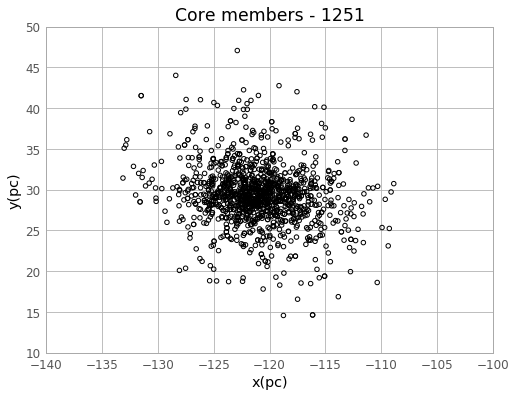


R(Center) = (x,y,z) = (-121.06,29.36,-54.68) pc
V(Center) = (u,v,w) = (-6.07,-28.63,-13.93) km*s^-1

Core member V: 46.55 km*s^-1


x          y          z         u          v          w    space_v
0 -131.501923  41.537231 -56.304828 -3.602727 -30.253768 -13.904535  33.490390
1 -131.997659  29.352175 -61.482347 -1.425277 -30.081952 -11.301430  32.166404
2 -131.599858  28.511350 -59.178214 -1.333364 -30.714985 -11.833007  32.942498
3 -127.475087  41.068593 -60.083092 -3.686910 -29.844602 -12.577369  32.595763
4 -127.962756  39.451877 -59.179611 -3.322661 -29.710334 -12.621786  32.450786

In [6]:
plt.scatter(core1['x'],core1['y'],s=20,edgecolors = 'k',facecolors='none')
plt.scatter(core2['x'],core2['y'],s=20,edgecolors = 'k',facecolors='none')
plt.xlim([-140,-100])
plt.ylim([10,50])
plt.xlabel('x(pc)')
plt.ylabel('y(pc)')
plt.title('Core members - {}'.format(len(core1)+len(core2)))
plt.show()

print('\nR(Center) = (x,y,z) = ({},{},{}) pc\nV(Center) = (u,v,w) = ({},{},{}) km*s^-1'\
      .format(rnd(np.mean(pd.concat([core1['x'],core2['x']]))),rnd(np.mean(pd.concat([core1['y'],core2['y']]))),\
              rnd(np.mean(pd.concat([core1['z'],core2['z']]))),rnd(np.mean(pd.concat([core1['u'],core2['u']]))),\
              rnd(np.mean(pd.concat([core1['v'],core2['v']]))),rnd(np.mean(pd.concat([core1['w'],core2['w']])))))
core_mean_v_mag = np.sqrt((43.43**2)+(0.51**2)+(16.74**2))
print('\nCore member V: {} km*s^-1'.format(rnd(core_mean_v_mag)))
core1.head()

In [7]:
# Heliocentric (Equitorial) coordinates
data = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Hyades/5pc.csv')

# Heliocentric -> Galactocentric (astroFrame())
HELIO = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Hyades/HELIO.csv')

# Removing peculiar motion of the sun. Previouslly used in my galactocentric coordinate conversion
HELIO['id'] = [i for i in range(len(HELIO))]
HELIO['u'] = HELIO['u'] - 11.1
HELIO['v'] = HELIO['v'] - 12.24
HELIO['w'] = HELIO['w'] - 7.25

pm_scalar = []
for i in range(len(data['pmra'])):
    pm_scalar.append(np.sqrt((data['pmra'][i]/1000)**2+(data['pmdec'][i]/1000)**2))
    
data['pm_scalar'] = pm_scalar
data['dist'] = 1/(data['parallax']/1000)
tang_V = [pm_scalar[i]*data['dist'][i]*4.74 for i in range(len(pm_scalar))] # km/s 
data['tang_v'] = tang_V

data.head()

source_id          ra  ra_error        dec  dec_error       pmra  \
0  5781834812959489920  236.645693  0.018643 -75.399888   0.019501   9.236133   
1  4464022263949414656  245.356079  0.023258  14.620676   0.020737 -54.763548   
2  4464036484584088320  245.225769  0.021291  14.721420   0.017986 -28.392495   
3  4464239692374461824  243.873518  0.028097  13.837664   0.024657  12.851653   
4  4464037004277180800  245.296127  0.022200  14.720871   0.021614 -45.613007   

   pmra_error      pmdec  pmdec_error  radial_velocity  radial_velocity_error  \
0    0.032575 -13.196771     0.041458         0.242497               0.957960   
1    0.041962 -32.305415     0.038548       -12.975678               0.320910   
2    0.040309  -6.300816     0.034020       -10.722656               0.928010   
3    0.057041 -15.392789     0.046000       -10.016315               0.527596   
4    0.039445  18.133144     0.039671       -16.469912               0.469753   

   parallax  parallax_error  phot_g_mean_mag  phot_bp_mean_mag  \
0  7.674512        0.023794        10.113231         10.429392   
1  6.365233        0.036161        10.194319         10.528229   
2  7.368490        0.033168        11.904952         12.428617   
3  5.309226        0.043505        10.264918         10.536487   
4  6.977435        0.036833        11.561617         12.022272   

   phot_rp_mean_mag  pm_scalar        dist     tang_v  
0          9.665930   0.016108  130.301442   9.948636  
1          9.729285   0.063582  157.103438  47.347716  
2         11.251430   0.029083  135.713018  18.708649  
3          9.864599   0.020053  188.351355  17.902584  
4         10.968613   0.049085  143.319151  33.345188

# (u,v,w) filtering informed by N-Body simulations 

In [73]:
FILT = []
FILT_raw = []

u = np.mean(pd.concat([core1['u'],core2['u']]))
v = np.mean(pd.concat([core1['v'],core2['v']]))
w = np.mean(pd.concat([core1['w'],core2['w']]))

for i in range(len(HELIO)):
    if HELIO['u'][i] >=  u-3 and HELIO['u'][i] <= u+3 and\
    HELIO['v'][i] >= v-3 and HELIO['v'][i] <= v+3 and\
    HELIO['w'][i] >= w-3 and HELIO['w'][i] <= w+3:
        FILT.append(list(HELIO.loc[i]))
        FILT_raw.append(list(data.loc[i]))
        
FILT = pd.DataFrame(FILT,columns = list(HELIO)) 
FILT_raw = pd.DataFrame(FILT_raw,columns = list(data)) 

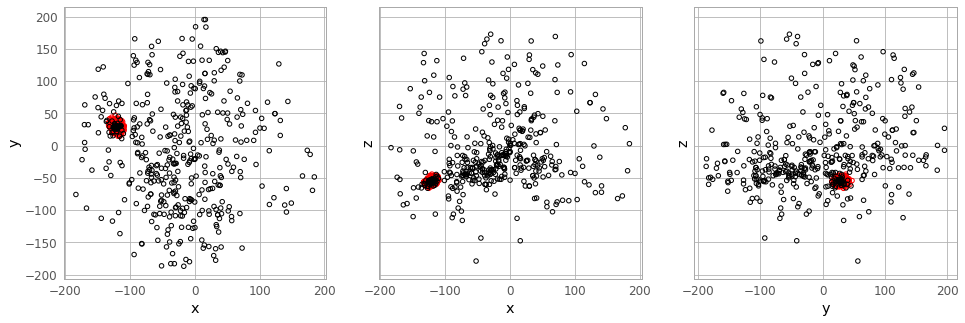

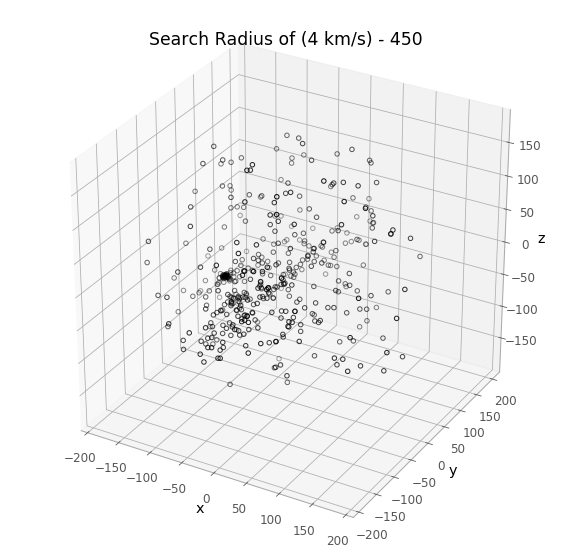

In [74]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))
ax1.scatter(core1['x'],core1['y'],s=20,edgecolors = 'r',facecolors='none')
ax1.scatter(core2['x'],core2['y'],s=20,edgecolors = 'r',facecolors='none')
ax1.scatter(FILT['x'],FILT['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')

ax2.scatter(core1['x'],core1['z'],s=1,edgecolors = 'r',facecolors='none')
ax2.scatter(core2['x'],core2['z'],s=20,edgecolors = 'r',facecolors='none')
ax2.scatter(FILT['x'],FILT['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')

ax3.scatter(core1['y'],core1['z'],s=1,edgecolors = 'r',facecolors='none')
ax3.scatter(core2['y'],core2['z'],s=20,edgecolors = 'r',facecolors='none')
ax3.scatter(FILT['y'],FILT['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(FILT)))

ax.scatter3D(FILT['x'], FILT['y'], FILT['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

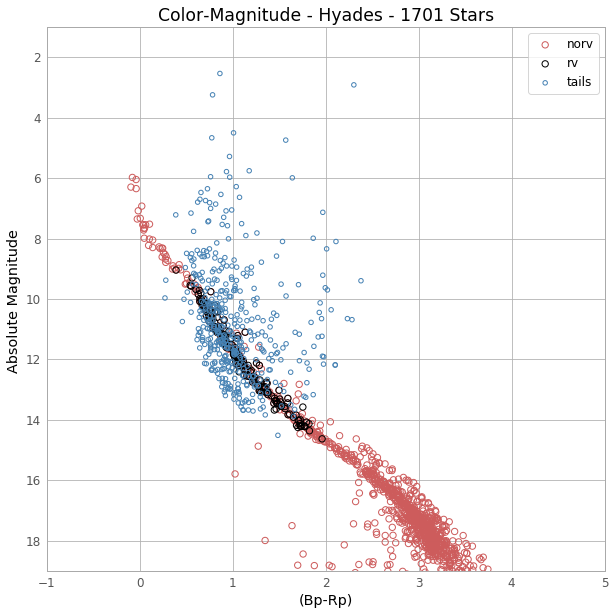

In [138]:
plt.figure(figsize=(10,10))
plt.title('Color-Magnitude - Hyades - {} Stars'.format(len(FILT_raw)+len(pleia1)+len(pleia2)))
plt.xlabel('(Bp-Rp)')
plt.ylabel('Absolute Magnitude ')
plt.xlim([-1,5])
plt.ylim([19,1])

M_g = [abs_mag(pleia2['phot_g_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
M_rp = [abs_mag(pleia2['phot_rp_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
M_b = [abs_mag(pleia2['phot_bp_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=40,edgecolors = '#cd5c5c',facecolors='none')

M_g = [abs_mag(pleia1['phot_g_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
M_rp = [abs_mag(pleia1['phot_rp_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
M_b = [abs_mag(pleia1['phot_bp_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=40,edgecolors = 'k',facecolors='none')

M_g = [abs_mag(FILT_raw['phot_g_mean_mag'][i],FILT_raw['parallax'][i]) for i in range(len(FILT_raw['ra']))]
M_rp = [abs_mag(FILT_raw['phot_rp_mean_mag'][i],FILT_raw['parallax'][i]) for i in range(len(FILT_raw['ra']))]
M_b = [abs_mag(FILT_raw['phot_bp_mean_mag'][i],FILT_raw['parallax'][i]) for i in range(len(FILT_raw['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=20,edgecolors = '#4682b4',facecolors='none')
plt.legend(['norv','rv','tails'])
plt.show()

# Action angle coordinates (Lz,Jr,Jz)

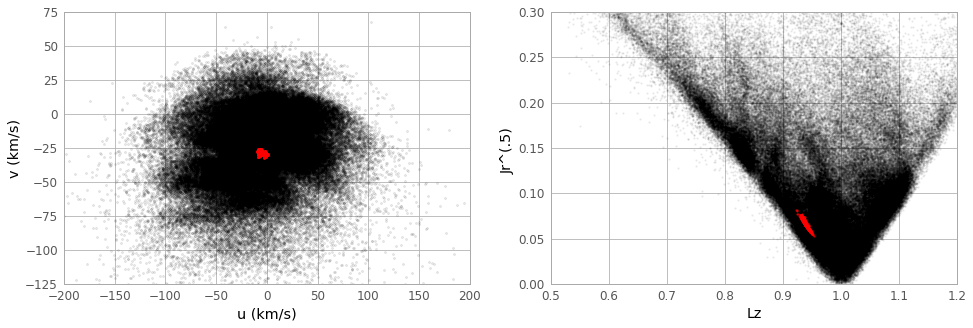

In [76]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,c=False) 

def stae(df):
    lis = []
    for i in range(len(df)):
        op= Orbit(vxvv=[df['ra'][i],df['dec'][i],1/(df['parallax'][i]/1000)/1000,\
               df['pmra'][i],df['pmdec'][i],df['radial_velocity'][i]],radec=True)
        lis.append(aAS(op))
    return lis

def stae1(df):
    lis = []
    for i in range(len(df)):
        op= Orbit(vxvv=[df['ra'][i],df['dec'][i],1/(df['parallax'][i]/1000)/1000,\
               df['pmra'][i],df['pmdec'][i],df['rad_v'][i]],radec=True)
        lis.append(aAS(op))
    return lis
        
#staeckel = pd.DataFrame(stae(data),columns = ['Jr','Lz','Jz'])
#staeckel.to_csv('staeckel_data.csv', encoding='utf-8', index=False)

staeckel = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Hyades/staeckel_data.csv')
tail_stae = pd.DataFrame(stae(FILT_raw),columns = ['Jr','Lz','Jz'])
coreA =  pd.DataFrame(stae1(pleia1),columns = ['Jr','Lz','Jz'])
coreB =  pd.DataFrame(stae1(pleia2),columns = ['Jr','Lz','Jz'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))
ax1.scatter(HELIO['u'],HELIO['v'],s=4,alpha = 0.075,c = 'k')
ax1.scatter(core1['u'],core1['v'],s = 3, c = 'r')
ax1.scatter(core2['u'],core2['v'],s = 3, c = 'r')
#ax1.scatter(FILT['u'],FILT['v'],s = 3, c = 'r')
ax1.set_xlabel('u (km/s)')
ax1.set_ylabel('v (km/s)')
ax1.set_xlim([-200,200])
ax1.set_ylim([-125,75])

ax2.scatter(staeckel['Lz'],(staeckel['Jr'])**.5,s=2,alpha = 0.05,c = 'k') #.01
ax2.scatter(coreB['Lz'],(coreB['Jr'])**.5,s=2,c= 'r',alpha = 0.5)
ax2.scatter(coreA['Lz'],(coreA['Jr'])**.5,s=2,c= 'r',alpha = 0.5)
#ax2.scatter(tail_stae['Lz'],(tail_stae['Jr'])**.5,s=2,c= 'w',alpha = 0.5)
ax2.set_xlabel('Lz')
ax2.set_ylabel('Jr^(.5) ')
ax2.set_xlim([0.5,1.2])
ax2.set_ylim([0,.3])
plt.show()

In [77]:
revEQ = []
revGAL = []
test = []
maxy = max(coreA['Jr']**.5)
miny = min(coreA['Jr']**.5)

maxx = max(coreA['Lz'])
minx = min(coreA['Lz'])

for i in range(len(staeckel)):
    if staeckel['Lz'][i] <= maxx and staeckel['Lz'][i] >= minx and\
    staeckel['Jr'][i]**.5 <= maxy and staeckel['Jr'][i]**.5 >= miny:
        revEQ.append(list(data.loc[i]))
        revGAL.append(list(HELIO.loc[i]))
       
revEQ = pd.DataFrame(revEQ, columns = list(data))
revGAL = pd.DataFrame(revGAL, columns = list(HELIO))

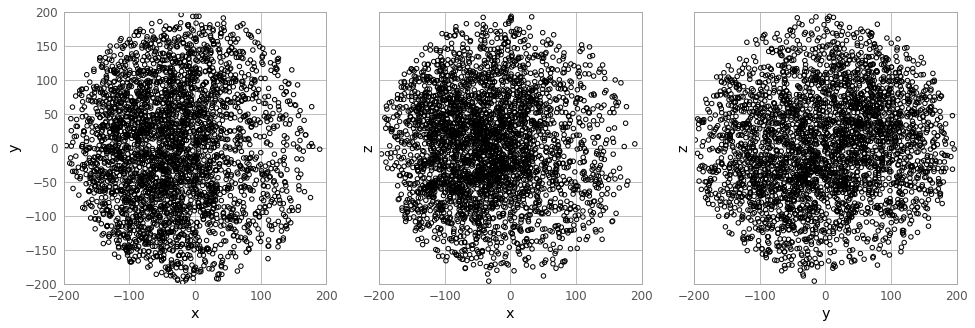

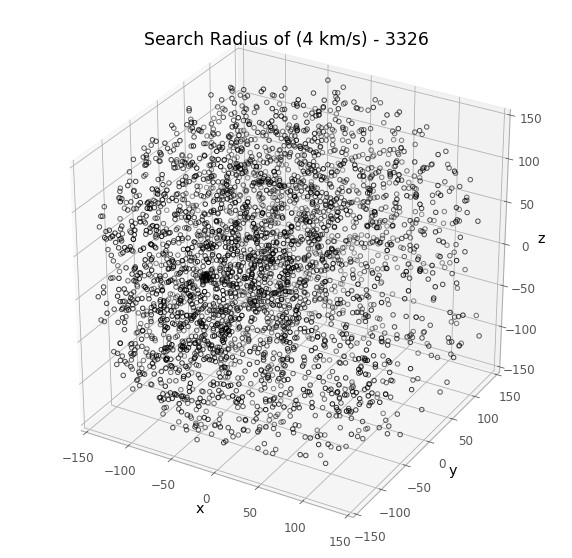

In [78]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))

ax1.scatter(revGAL['x'],revGAL['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])

ax2.scatter(revGAL['x'],revGAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

ax3.scatter(revGAL['y'],revGAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
ax3.set_xlim([-200,200])
ax3.set_ylim([-200,200])

plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])
ax.set_zlim([-150,150])
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(revEQ)))

ax.scatter3D(revGAL['x'], revGAL['y'], revGAL['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

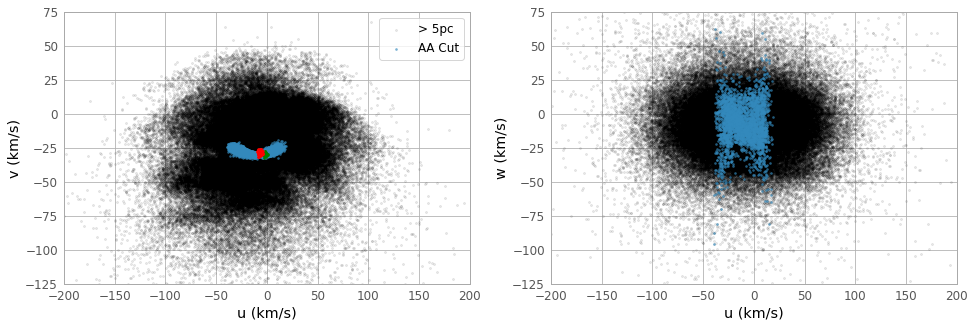

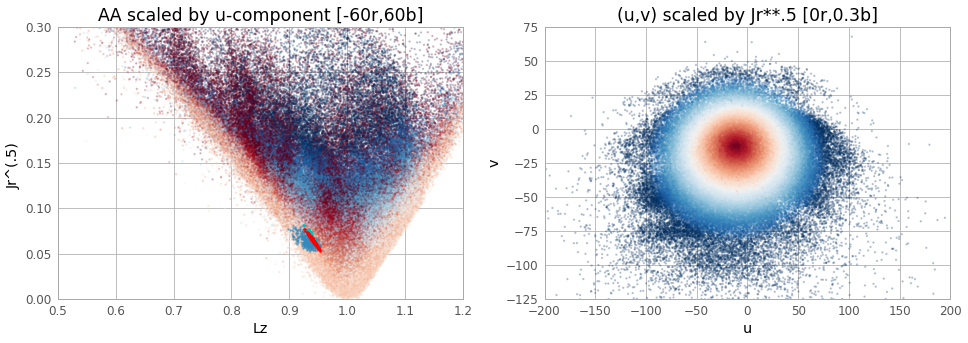

In [106]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))

ax1.scatter(HELIO['u'],HELIO['v'],s=4,alpha = 0.075,c = 'k')
ax1.scatter(revGAL['u'],revGAL['v'],s = 3,alpha = .5)
#ax1.scatter(FILT['u'],FILT['v'],s = 3, c = 'r',alpha = .75)

ax1.set_xlabel('u (km/s)')
ax1.set_ylabel('v (km/s)')
ax1.set_xlim([-200,200])
ax1.set_ylim([-125,75])
ax1.legend(['> 5pc','AA Cut','Tail + Core'],loc = 'upper right')

ax2.scatter(HELIO['u'],HELIO['w'],s=4,alpha = 0.075,c = 'k')
ax2.scatter(revGAL['u'],revGAL['w'],s = 3,alpha = .5)
ax1.scatter(core1['u'],core1['v'],color = 'g',s=2)
ax1.scatter(core2['u'],core2['v'],color = 'r',s=2)
#ax2.scatter(FILT['u'],FILT['w'],s = 3, c = 'r',alpha = .75)

ax2.set_xlabel('u (km/s)')
ax2.set_ylabel('w (km/s)')
ax2.set_xlim([-200,200])
ax2.set_ylim([-125,75])
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))

u = HELIO['u']
norm = plt.Normalize(vmin=-50, vmax=50)
ax1.scatter(staeckel['Lz'],(staeckel['Jr'])**.5,s=2,alpha = 0.2,c=u,norm=norm,cmap = 'RdBu')
#ax1.colorbar()
ax1.scatter(tail_stae['Lz'],(tail_stae['Jr'])**.5,s=2,alpha = 0.5)
ax1.scatter(coreA['Lz'],(coreA['Jr'])**.5,color = 'c',s=2)
ax1.scatter(coreB['Lz'],(coreB['Jr'])**.5,color = 'r',s=2)
ax1.set_xlabel('Lz')
ax1.set_ylabel('Jr^(.5) ')
ax1.set_xlim([0.5,1.2])
ax1.set_ylim([0,.3])
ax1.set_title('AA scaled by u-component [-60r,60b]')

u = staeckel['Jr']**.5
norm = plt.Normalize(vmin=0, vmax=.25)
ax2.scatter(HELIO['u'],HELIO['v'],s=2,alpha = 0.2,c=u,norm=norm,cmap = 'RdBu')
ax2.set_xlabel('u')
ax2.set_ylabel('v')
ax2.set_xlim([-200,200])
ax2.set_ylim([-125,75])
ax2.set_title('(u,v) scaled by Jr**.5 [0r,0.3b]')
plt.show()

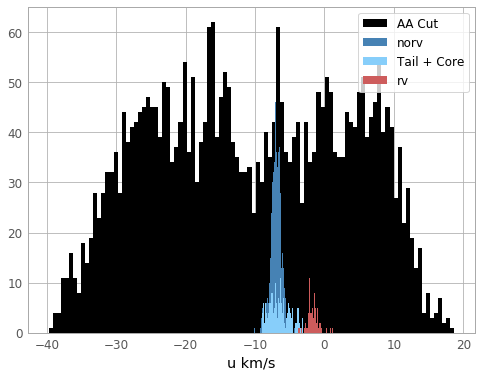

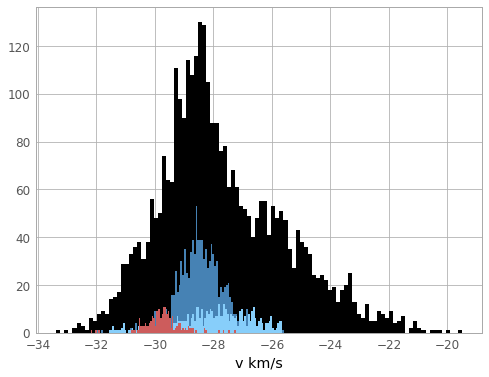

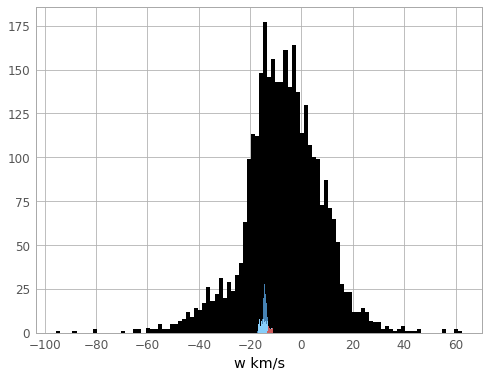

In [144]:
plt.hist(revGAL['u'],bins=100,color = 'k')
plt.hist(core2['u'],color ='#4682b4',bins =100)
plt.hist(FILT['u'],bins=100,color='#87cefa')
plt.hist(core1['u'],color = '#cd5c5c',bins = 100)
plt.xlabel('u km/s')
plt.legend(['AA Cut','norv','Tail + Core','rv'],loc = 'upper right')
plt.show()

plt.hist(revGAL['v'],bins=100,color = 'k')
plt.hist(core2['v'],color ='#4682b4',bins =100)
plt.hist(FILT['v'],bins=100,color='#87cefa')
plt.hist(core1['v'],color = '#cd5c5c',bins = 100)
plt.xlabel('v km/s')
plt.show()

plt.hist(revGAL['w'],bins=100,color = 'k')
plt.hist(core2['w'],color ='#4682b4',bins =100)
plt.hist(FILT['w'],bins=100,color='#87cefa')
plt.hist(core1['w'],color = '#cd5c5c',bins =100)
plt.xlabel('w km/s')
plt.show()

In [26]:
testGAL = pd.DataFrame(revGAL, columns = list(revGAL))
testRAW = pd.DataFrame(revEQ, columns = list(revEQ))

In [27]:
# Spatial Density Filter

starz = []
rawz = []

def spherical(x,y,z):
    rho = np.sqrt(x**2+y**2+z**2)
    phi = np.arccos(z/rho)
    theta = np.arctan(y/x)
    lis = [rho,abs(theta),abs(phi)]
    return lis

for o in range(len(testGAL)):
    
    count = 0

    x,y,z = testGAL['x'][o],testGAL['y'][o],testGAL['z'][o]
    
    if x - x == 0: dx = -x
    else: dx = x
    if y - y == 0: dy = -y
    else: dy = x
    if z - z == 0: dz = -z
    else: dz = z
    
    for i in range(len(testGAL)):
        coords = spherical(testGAL['x'][i] + dx, testGAL['y'][i] + dy, testGAL['z'][i] + dz)
        if coords[0] < 20:
            count += 1
            
    if count > 4: 
        starz.append(list(testGAL.loc[o]))
        rawz.append(list(testRAW.loc[o]))
               
starz = pd.DataFrame(starz,columns = list(testGAL))   
rawz = pd.DataFrame(rawz,columns = list(testRAW))

/Users/landonbuechner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  

/Users/landonbuechner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':



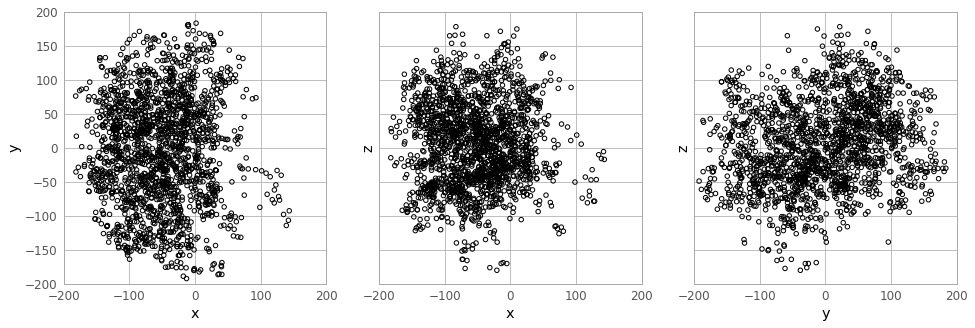

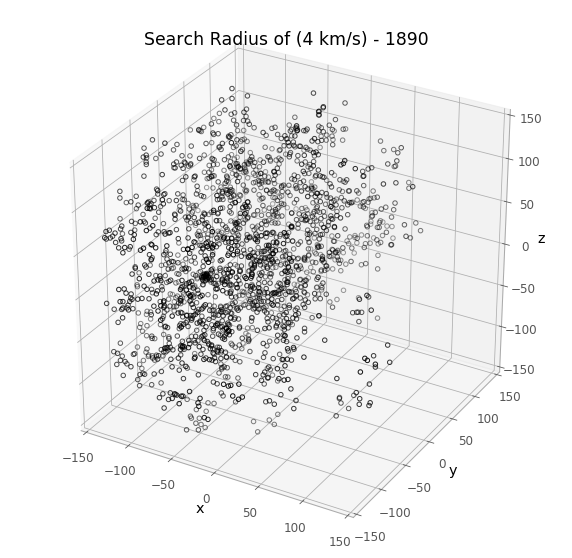

In [28]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))

ax1.scatter(starz['x'],starz['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])

ax2.scatter(starz['x'],starz['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

ax3.scatter(starz['y'],starz['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
ax3.set_xlim([-200,200])
ax3.set_ylim([-200,200])

plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])
ax.set_zlim([-150,150])
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(starz)))

ax.scatter3D(starz['x'], starz['y'], starz['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

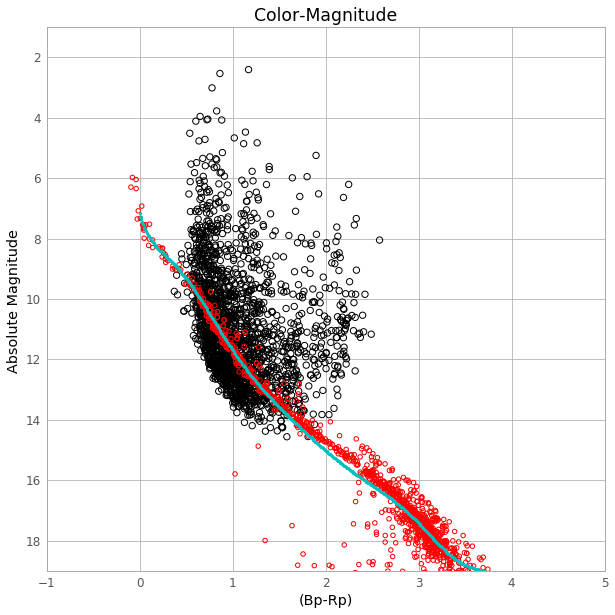

In [39]:
plt.figure(figsize=(10,10))
plt.title('Color-Magnitude')
plt.xlabel('(Bp-Rp)')
plt.ylabel('Absolute Magnitude ')
plt.xlim([-1,5])
plt.ylim([19,1])

# plotting all stars that satisfy filtering in (Lz,Jr) space
M_g_raw = [abs_mag(rawz['phot_g_mean_mag'][i],rawz['parallax'][i]) for i in range(len(rawz['ra']))]
M_rp_raw  = [abs_mag(rawz['phot_rp_mean_mag'][i],rawz['parallax'][i]) for i in range(len(rawz['ra']))]
M_b_raw = [abs_mag(rawz['phot_bp_mean_mag'][i],rawz['parallax'][i]) for i in range(len(rawz['ra']))]
CI_raw = color(M_rp_raw,M_b_raw)
plt.scatter(CI_raw, M_g_raw,marker='o',s=40,edgecolors = 'k',facecolors='none')

# plot of hyades core stars that have observed radial velocities
M_g1 = [abs_mag(pleia1['phot_g_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
M_rp = [abs_mag(pleia1['phot_rp_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
M_b = [abs_mag(pleia1['phot_bp_mean_mag'][i],pleia1['parallax'][i]) for i in range(len(pleia1['ra']))]
CI1 = color(M_rp,M_b)
plt.scatter(CI1, M_g1,marker='o',s=20,edgecolors = 'r',facecolors='none')

M_g2 = [abs_mag(pleia2['phot_g_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
M_rp = [abs_mag(pleia2['phot_rp_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
M_b = [abs_mag(pleia2['phot_bp_mean_mag'][i],pleia2['parallax'][i]) for i in range(len(pleia2['ra']))]
CI2 = color(M_rp,M_b)
plt.scatter(CI2, M_g2,marker='o',s=20,edgecolors = 'r',facecolors='none')

M_gA = M_g1 + M_g2
CI_A = CI1 + CI2
# fitting polynomial through observed core members 
Poly = np.poly1d(np.polyfit(CI1,M_g1,10))
PolyA = np.poly1d(np.polyfit(CI_A,M_gA,10))
x = [np.arange(0,5,.01)]
y = list(PolyA(x))
plt.scatter(x,y,s = 5,c='c')
plt.show()

In [50]:
# only working with stars thave have - u
control = .5

CMD_GAL = []
CMD_raw = []
for i in range(len(rawz)):
    if abs(Poly(CI_raw[i]) - M_g_raw[i]) < control:
        CMD_GAL.append(list(starz.loc[i]))
        CMD_raw.append(list(rawz.loc[i]))
        
CMD_GAL = pd.DataFrame(CMD_GAL,columns = list(revGAL))
CMD_raw = pd.DataFrame(CMD_raw,columns = list(revEQ))     

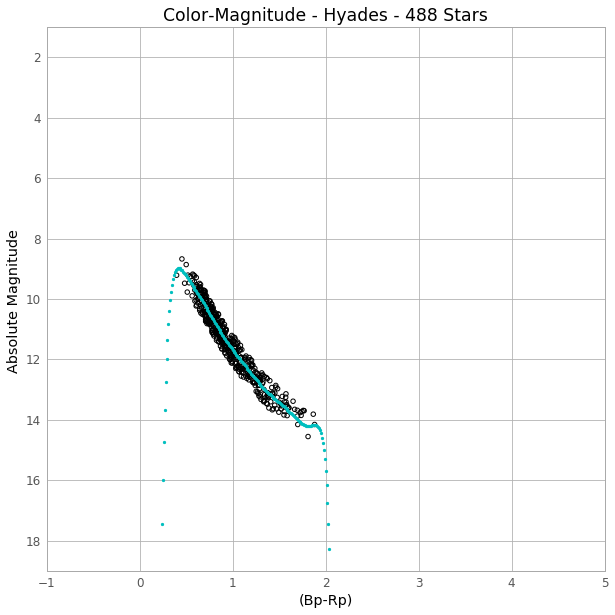

In [51]:
plt.figure(figsize=(10,10))
plt.title('Color-Magnitude - Hyades - {} Stars'.format(len(CMD_raw)))
plt.xlabel('(Bp-Rp)')
plt.ylabel('Absolute Magnitude ')
plt.xlim([-1,5])
plt.ylim([19,1])

M_g = [abs_mag(CMD_raw['phot_g_mean_mag'][i],CMD_raw['parallax'][i]) for i in range(len(CMD_raw['ra']))]
M_rp = [abs_mag(CMD_raw['phot_rp_mean_mag'][i],CMD_raw['parallax'][i]) for i in range(len(CMD_raw['ra']))]
M_b = [abs_mag(CMD_raw['phot_bp_mean_mag'][i],CMD_raw['parallax'][i]) for i in range(len(CMD_raw['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=20,edgecolors = 'k',facecolors='none')

Poly = np.poly1d(np.polyfit(CI1,M_g1,10))
x = [np.arange(0,5,.01)]
y = list(Poly(x))
plt.scatter(x,y,s = 5,c='c')

plt.show()

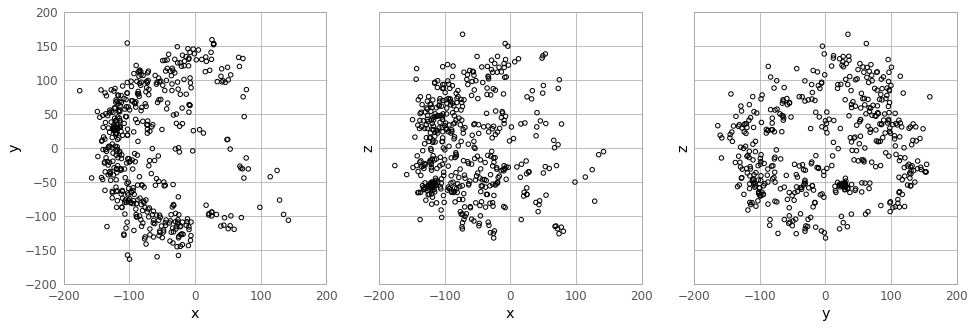

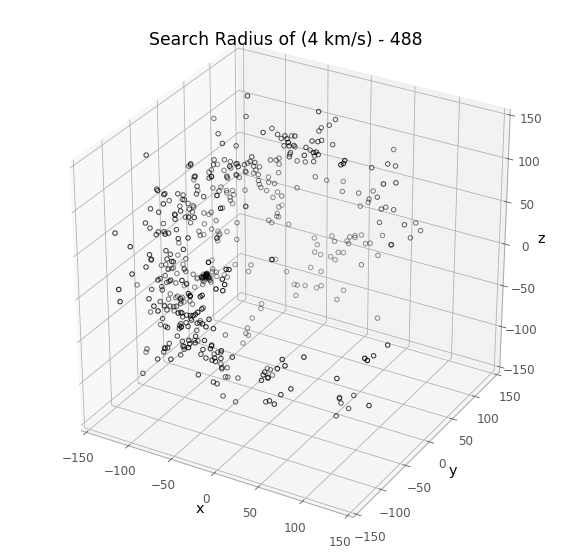

In [52]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))

ax1.scatter(CMD_GAL['x'],CMD_GAL['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])

ax2.scatter(CMD_GAL['x'],CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

ax3.scatter(CMD_GAL['y'],CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
ax3.set_xlim([-200,200])
ax3.set_ylim([-200,200])

plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])
ax.set_zlim([-150,150])
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(CMD_GAL)))

ax.scatter3D(CMD_GAL['x'], CMD_GAL['y'], CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

# Artifact Probe

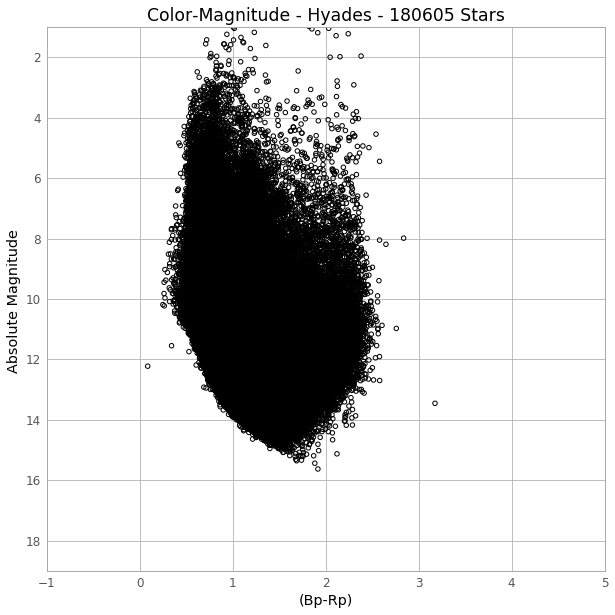

In [62]:
artifact_probe = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/Hyades/5pc.csv')

plt.figure(figsize=(10,10))
plt.title('Color-Magnitude - Hyades - {} Stars'.format(len(artifact_probe)))
plt.xlabel('(Bp-Rp)')
plt.ylabel('Absolute Magnitude ')
plt.xlim([-1,5])
plt.ylim([19,1])

M_g = [abs_mag(artifact_probe['phot_g_mean_mag'][i],artifact_probe['parallax'][i]) for i in range(len(artifact_probe['ra']))]
M_rp = [abs_mag(artifact_probe['phot_rp_mean_mag'][i],artifact_probe['parallax'][i]) for i in range(len(artifact_probe['ra']))]
M_b = [abs_mag(artifact_probe['phot_bp_mean_mag'][i],artifact_probe['parallax'][i]) for i in range(len(artifact_probe['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=20,edgecolors = 'k',facecolors='none')

plt.show()

control = .03

CMD_GAL = []
CMD_raw = []
for i in range(len(artifact_probe)):
    if abs(Poly(CI[i]) - M_g[i]) < control:
        CMD_GAL.append(list(HELIO.loc[i]))
        CMD_raw.append(list(artifact_probe.loc[i]))
        
CMD_GAL = pd.DataFrame(CMD_GAL,columns = list(HELIO))
CMD_raw = pd.DataFrame(CMD_raw,columns = list(artifact_probe))    


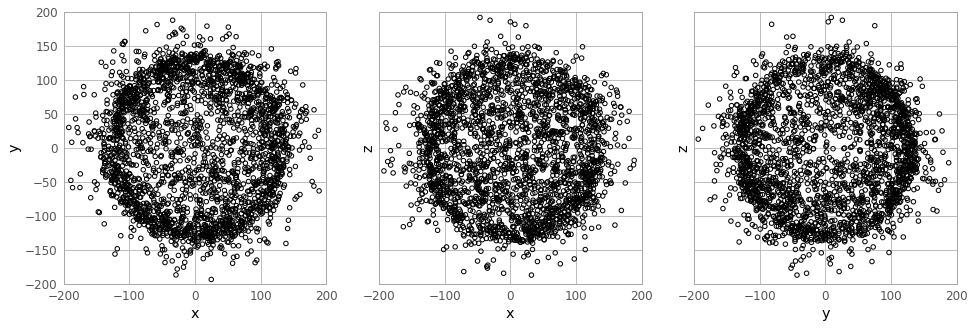

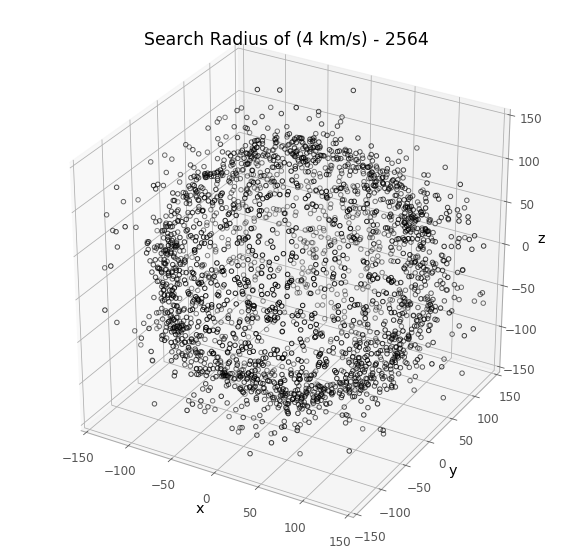

In [63]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))

ax1.scatter(CMD_GAL['x'],CMD_GAL['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])

ax2.scatter(CMD_GAL['x'],CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

ax3.scatter(CMD_GAL['y'],CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
ax3.set_xlim([-200,200])
ax3.set_ylim([-200,200])

plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])
ax.set_zlim([-150,150])
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(CMD_GAL)))

ax.scatter3D(CMD_GAL['x'], CMD_GAL['y'], CMD_GAL['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()